In [3]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                             if x[1] > 0 else x[0], axis=1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
  return new_feature_name_df

def get_human_dataset():
  #feature.txt 파일에는 피처 이름 index와 ㅍ첨ㅇ이 공백으로 분리되어 있음, 이를 DataFrame으로 로드  
  feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', header=None, names=['column_index','column_name'])
  
  # 중복된 피처명을 수정하는 get_enw_feature_name_df() 를 이용 
  new_feature_name_df = get_new_feature_name_df(feature_name_df)
  
  # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환 
  feature_name = new_feature_name_df.iloc[:,1].values.tolist()
  
  # 학습 피처 데이터세트와 테스트피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용 
  X_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names=feature_name)
  X_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', names=feature_name)
  
  # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩. 칼럼명은 action으로 적용 
  y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
  y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
  
  # 로드된 하급/테스트용 DataFrame을 모두 반환
  return X_train, X_test, y_train, y_test

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_datset()를 이용해 학습/테스트용 DataFrame반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print("랜덤 포레스트 정확도: {0:.4f}".format(accuracy))

랜덤 포레스트 정확도: 0.9253


In [7]:
from sklearn.model_selection import GridSearchCV

params = {
  'n_estimators':[100],
  'max_depth':[6,8,10,12],
  'min_samples_leaf':[8,12,18],
  'min_samples_split':[8,16,20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
# n_jobjs= - 1 설정: 모든 CPU 코어를 이용해 학습할 수 있음
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print("최적 하이퍼 파라미터 \n", grid_cv.best_params_)
print("최고 예측 정확도: {0:.4f}".format(grid_cv.best_score_))

최적 하이퍼 파라미터 
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [9]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8,
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print("예측 정확도: {0:.4f}".format(accuracy_score(y_test, pred)))

예측 정확도: 0.9165


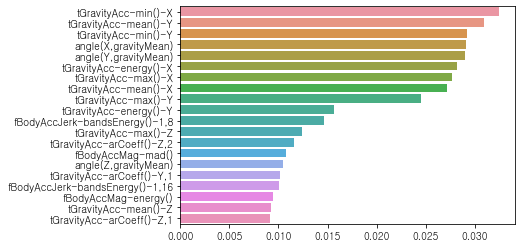

In [15]:
# 중요도 피처 시각화(랜덤 포레스트도 결정트리와 같이 변수 중요도를 살펴 볼 수 있다)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importance_values = rf_clf1.feature_importances_
ftr_importance_values = pd.Series(ftr_importance_values, index=X_train.columns)
ftr_top20 = ftr_importance_values.sort_values(ascending=False)[:20]

sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()